In [45]:
import os
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tqdm import tqdm

# import necessory libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch import optim



In [46]:
# # Preparing the Dataset :

# stanford car data 5 classes
data_dir = "/kaggle/input/stanford-5classes/Stanford2015_with_5_classes/car_data/car_data/train"
test_data_dir = "/kaggle/input/stanford-5classes/Stanford2015_with_5_classes/car_data/car_data/test"

# # stanford car data
# data_dir = "/kaggle/input/stanfordcarswithclasses/Stanford2015_with_classes/car_data/car_data/train"
# test_data_dir = "/kaggle/input/stanfordcarswithclasses/Stanford2015_with_classes/car_data/car_data/test"

vehicle_files = os.listdir(data_dir)
print(f"Number of Classes : {len(vehicle_files)}")
print(vehicle_files[:5])

Number of Classes : 5
['BMW_Z4_Convertible_2012', 'Buick_Enclave_SUV_2012', 'Acura_ZDX_Hatchback_2012', 'Aston_Martin_V8_Vantage_Convertible_2012', 'Audi_TTS_Coupe_2012']


In [47]:
dir = vehicle_files[0]
dir_next = data_dir + dir
dir_next

'/kaggle/input/stanford-5classes/Stanford2015_with_5_classes/car_data/car_data/trainBMW_Z4_Convertible_2012'

In [48]:
n_images = np.zeros(len(vehicle_files))
for i in range(len(vehicle_files)):
    dir = data_dir + vehicle_files[i]
    n_images[i] = len(dir)
n_images[:5]

array([106., 105., 107., 123., 102.])

In [49]:
def plot_im_dist(n_images, n_points):
    labels = np.arange(n_points)
    x = n_images[:n_points]
    y = labels[:n_points]
    fig, ax = plt.subplots()
    ax.bar(y, x)
    ax.set_ylabel('No. of images')
    ax.set_xlabel('Vehicle make and model class index')
    ax.set_title('Number of images by the first 100 vehicle make and model')
    fig.savefig('dataset_dist.pdf')
    fig.show()
# plot_im_dist(n_images, 60)

In [50]:
dataset = ImageFolder(data_dir, transform=transforms.Compose([
    transforms.Resize((150, 150)), transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir, transforms.Compose([
    transforms.Resize((150, 150)), transforms.ToTensor()
]))

img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 150, 150]) 0


In [51]:
print(f"Images in training data : {len(dataset)}")
print(f"Images in test data : {len(test_dataset)}")

Images in training data : 210
Images in test data : 208


In [52]:
len(dataset.classes)

5

In [53]:
len(test_dataset.classes)

5

In [54]:
print("Follwing classes are there : \n", dataset.classes)

Follwing classes are there : 
 ['Acura_ZDX_Hatchback_2012', 'Aston_Martin_V8_Vantage_Convertible_2012', 'Audi_TTS_Coupe_2012', 'BMW_Z4_Convertible_2012', 'Buick_Enclave_SUV_2012']


In [55]:
def display_img(img, label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1, 2, 0))

Label : Acura_ZDX_Hatchback_2012


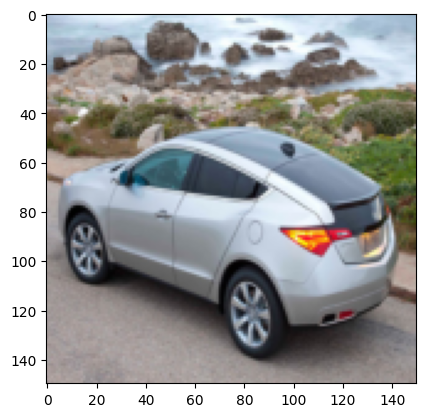

In [56]:
display_img(*dataset[0])

Label : Acura_ZDX_Hatchback_2012


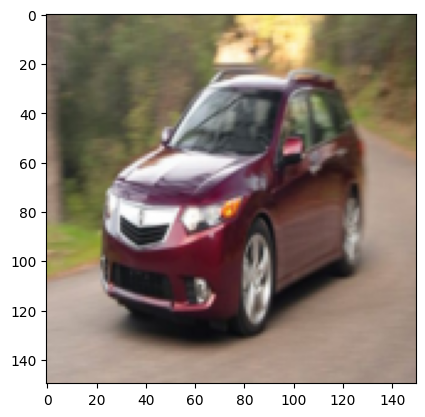

In [57]:
display_img(*dataset[30])

Label : Audi_TTS_Coupe_2012


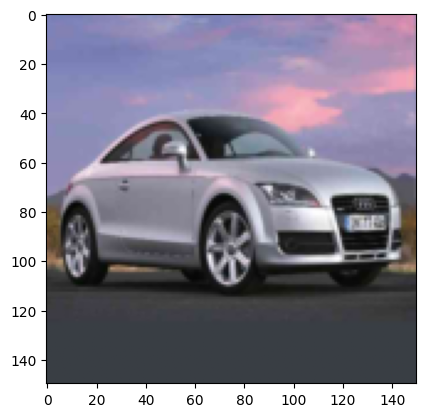

In [58]:
display_img(*dataset[90])

In [59]:
random_seed = 2
torch.manual_seed(random_seed)

In [60]:
val_size = np.floor(0.2 * len(dataset)).astype(int)
train_size = len(dataset) - val_size

In [61]:
train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 168
Length of Validation Data : 42


In [62]:
batch_size = 32

train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_data, batch_size * 2, num_workers=4, pin_memory=True)

In [63]:
torch.cuda.is_available()

False

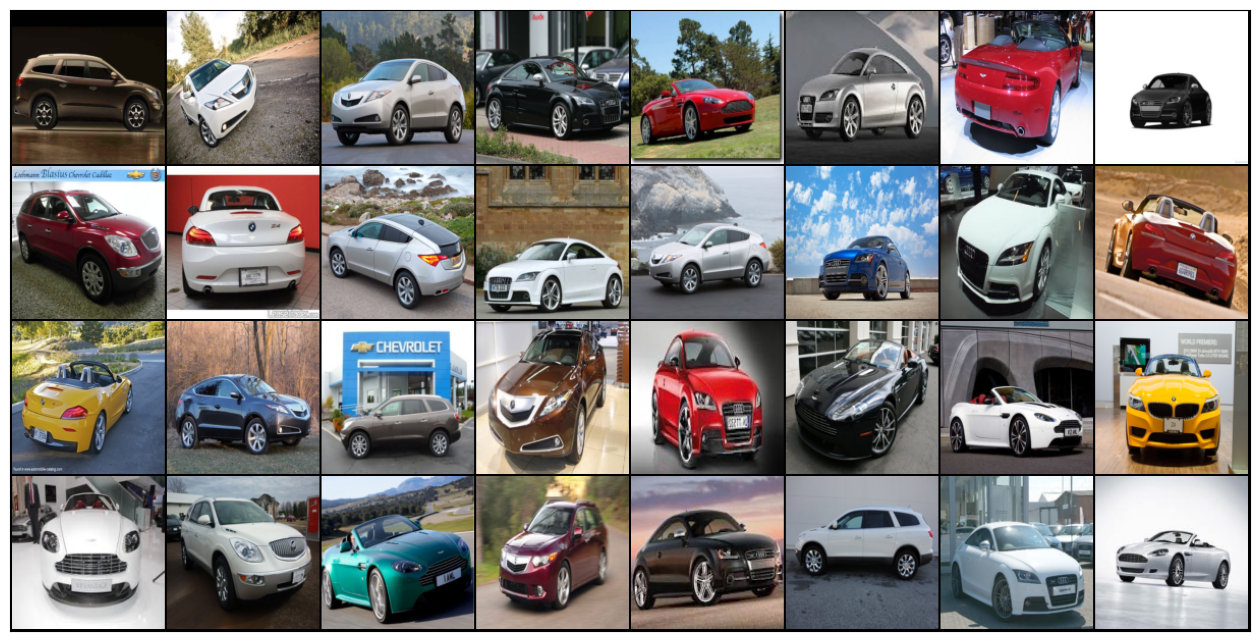

In [64]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        fig.savefig('fig_batch.pdf')
        break

show_batch(train_dl)

# Model

In [65]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
#         print("validation_step out: ", out)
#         print("validation_step labels: ", labels)
#         print("validation_step out shape: ", out.shape)
#         print("validation_step labels shape: ", labels.shape)
#         print(out==labels)
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class VehicleClassification(ImageClassificationBase):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(82944, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 6)
        )
    def forward(self, xb):
        return self.network(xb)

In [66]:
model = VehicleClassification()
model

VehicleClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(

In [67]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 150, 150])
out.shape: torch.Size([32, 6])
out[0]: tensor([-0.0171, -0.0224,  0.0262, -0.0021, -0.0140,  0.0080],
       grad_fn=<SelectBackward0>)


In [68]:
def get_default_device():
    """ Set Device to GPU or CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    "Move data to the device"
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [69]:
class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [70]:
device = get_default_device()
device

device(type='cpu')

In [71]:
# load the into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

VehicleClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(

In [72]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [73]:
# load the model to the device
model = to_device(VehicleClassification(), device)

In [74]:
# initial evaluation of the model
evaluate(model, val_dl)

{'val_loss': 1.787987470626831, 'val_acc': 0.1666666716337204}

In [75]:
num_epochs = 30
lr = 0.001

# fitting the model on training data and record the result after each epoch
# history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
history = fit(num_epochs, lr, model, train_dl, val_dl)

Epoch [0], train_loss: 1.7862, val_loss: 1.7877, val_acc: 0.1667
Epoch [1], train_loss: 1.7873, val_loss: 1.7874, val_acc: 0.1667
Epoch [2], train_loss: 1.7864, val_loss: 1.7871, val_acc: 0.1667
Epoch [3], train_loss: 1.7852, val_loss: 1.7868, val_acc: 0.1667
Epoch [4], train_loss: 1.7856, val_loss: 1.7865, val_acc: 0.1667
Epoch [5], train_loss: 1.7851, val_loss: 1.7862, val_acc: 0.1667
Epoch [6], train_loss: 1.7845, val_loss: 1.7859, val_acc: 0.1667
Epoch [7], train_loss: 1.7846, val_loss: 1.7856, val_acc: 0.1667
Epoch [8], train_loss: 1.7841, val_loss: 1.7853, val_acc: 0.1667
Epoch [9], train_loss: 1.7839, val_loss: 1.7850, val_acc: 0.1667
Epoch [10], train_loss: 1.7839, val_loss: 1.7847, val_acc: 0.1667
Epoch [11], train_loss: 1.7835, val_loss: 1.7844, val_acc: 0.1667
Epoch [12], train_loss: 1.7834, val_loss: 1.7841, val_acc: 0.1667
Epoch [13], train_loss: 1.7821, val_loss: 1.7839, val_acc: 0.1667
Epoch [14], train_loss: 1.7840, val_loss: 1.7836, val_acc: 0.1667
Epoch [15], train_lo

# Visualization

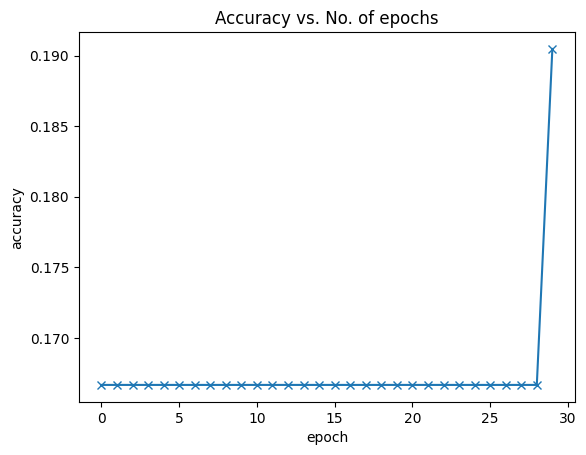

In [76]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.savefig('accuracy_vs_epochs.pdf')


plot_accuracies(history)

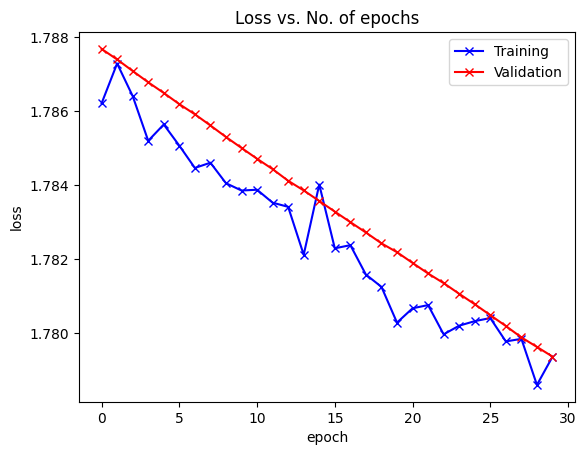

In [77]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.savefig('loss_vs_epochs.pdf')

plot_losses(history)

In [78]:
# Apply the model on test dataset and Get the results
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size * 2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 1.7764745950698853, 'val_acc': 0.36328125}

/tmp/ipykernel_42/1880733057.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_values)


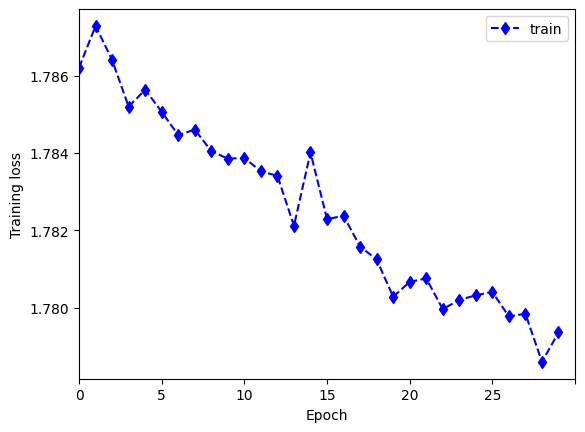

In [79]:
def plot_loss(training_losses, model_name):
    fig, ax = plt.subplots()
    ax.plot(training_losses, 'bd', linestyle='--', label='train')
    #     ax.set_title("Train and test accuracies")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training loss')
    x_values = np.arange(0, len(training_losses), step=5)
    ax.set_xticklabels(x_values)
    ax.legend()
    ax.set_xlim((0, len(training_losses)))
    fig.savefig(f'fig_{model_name}_training_losses.pdf')


train_losses = [x.get('train_loss') for x in history]
plot_loss(train_losses, 'CNN')

/tmp/ipykernel_42/434932516.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_values)


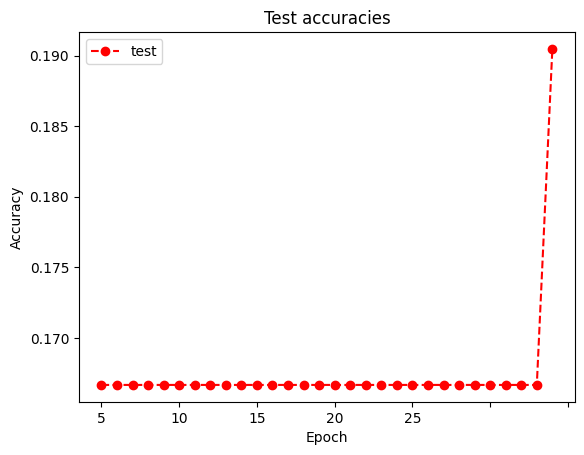

In [80]:
def plot_test_accuracies(test_accs, model_name):
    fig, ax = plt.subplots()
    ax.plot(test_accs, 'ro', linestyle='--', label='test')
    ax.set_title("Test accuracies")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    x_values = np.arange(0, len(test_accs), step=5)
    ax.set_xticklabels(x_values)
    ax.legend()
    fig.savefig(f'fig_{model_name}_test_accuracies.pdf')

test_accuracies = [x['val_acc'] for x in history]
plot_test_accuracies(test_accuracies, 'CNN')

In [81]:
test_accuracies

[0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.1666666716337204,
 0.190476194024086]